In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torchsummary import summary
import pandas as pd
import time

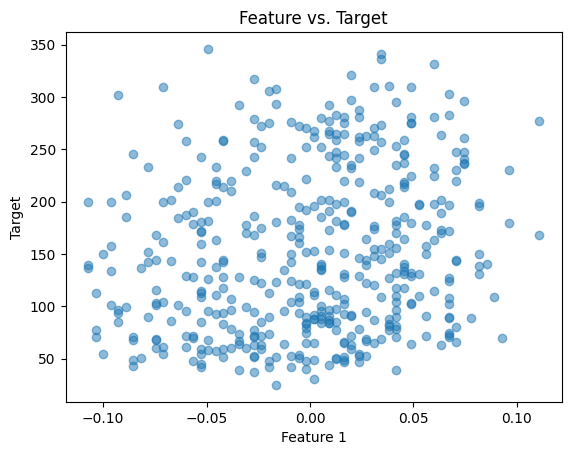

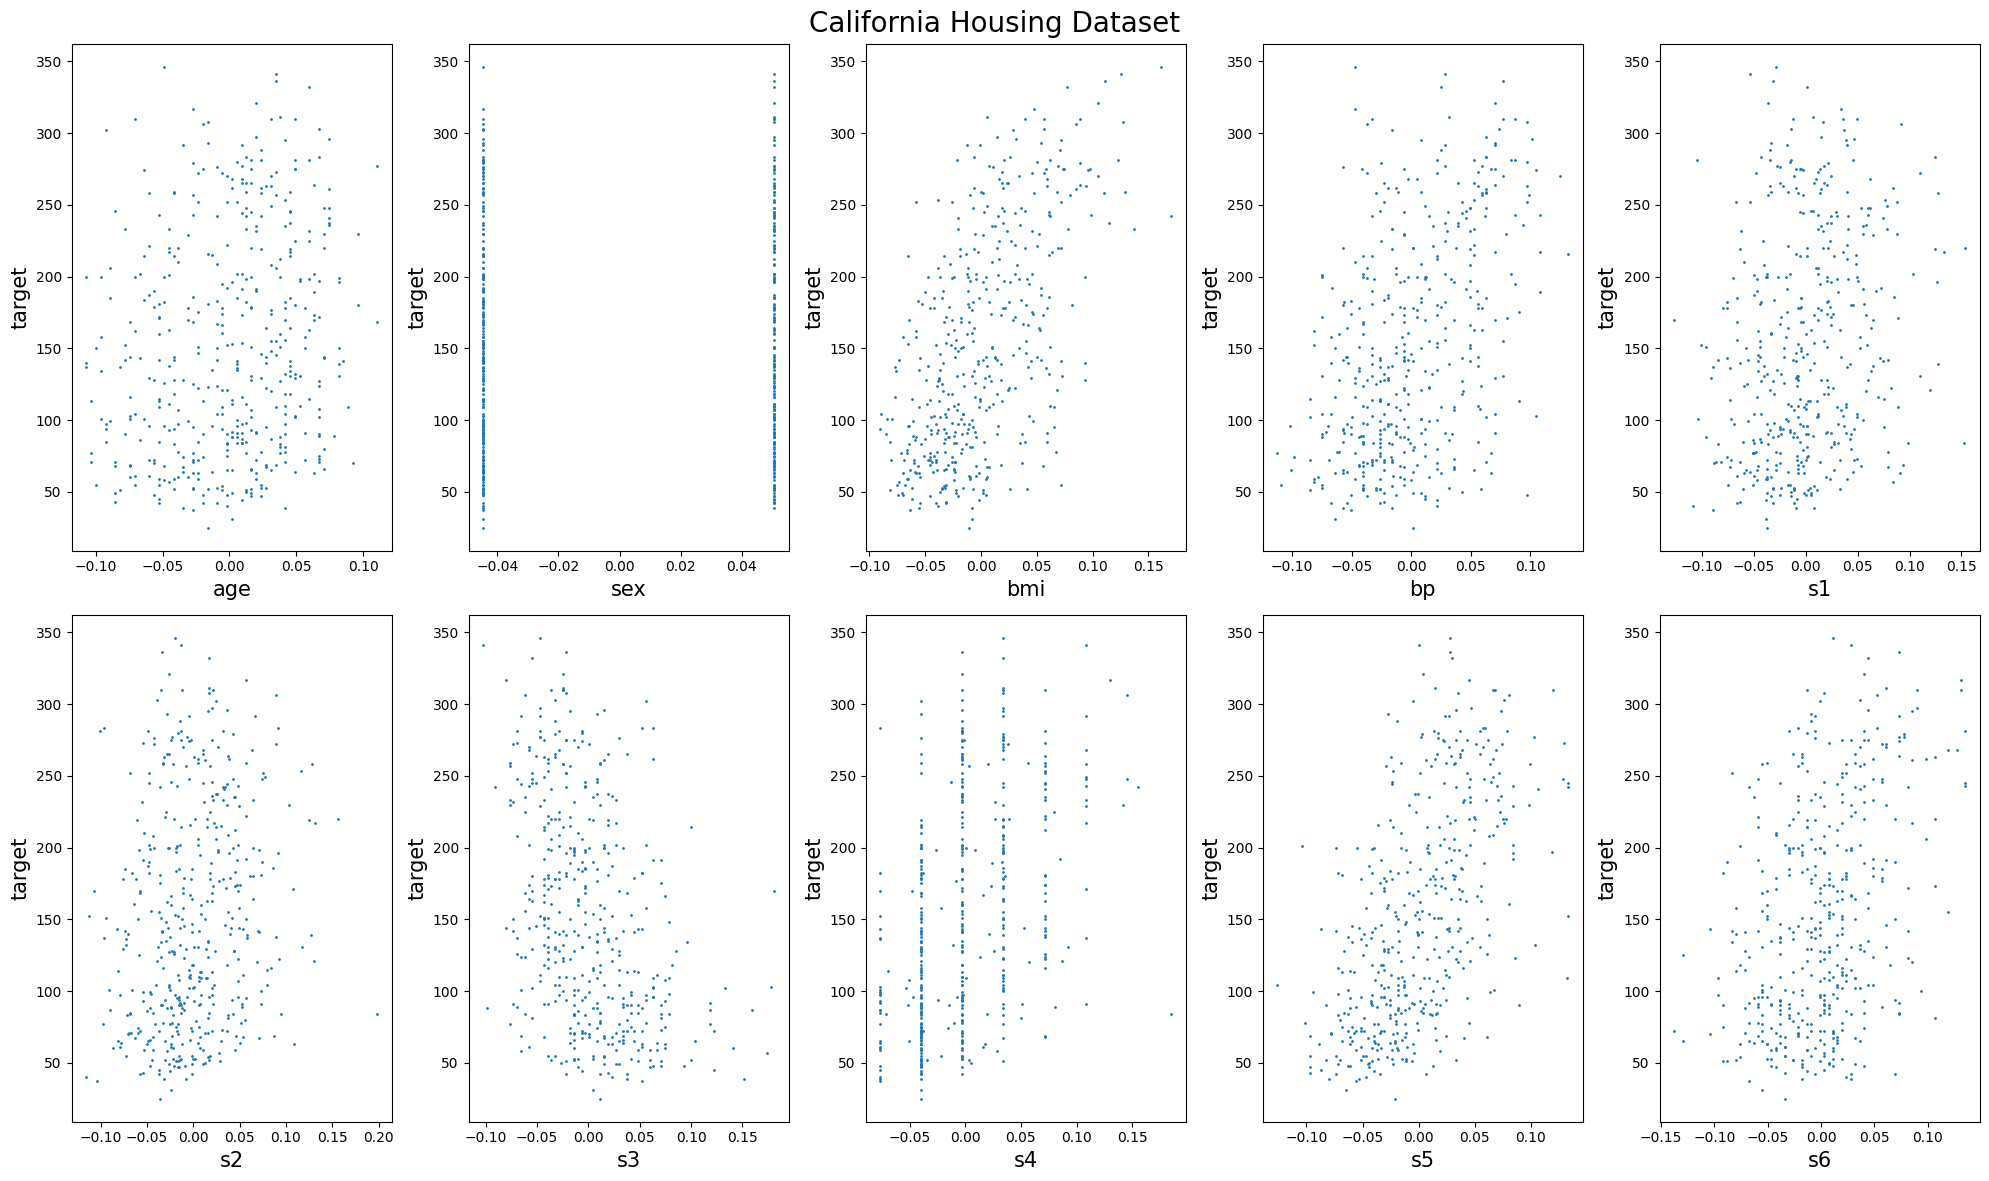

In [2]:
data = load_diabetes()
X, y = data.data, data.target

# Plot the first feature against the target
plt.scatter(X[:, 0], y, alpha=0.5)
plt.title("Feature vs. Target")
plt.xlabel("Feature 1")
plt.ylabel("Target")
plt.show()

fig, axs=plt.subplots(2,5,figsize=(20, 12))
fig.suptitle("California Housing Dataset", fontsize=20)
for i in range(2):
    for j in range(5):
        n=j+i*5
        ft=data.feature_names[n]
        axs[i,j].scatter(X[:,n],y,s=1)
        axs[i,j].set_xlabel(ft, fontsize=15)
        axs[i,j].set_ylabel("target", fontsize=15)

plt.tight_layout()
plt.savefig('datasetvis',dpi=300)
plt.show()

In [6]:
#define a more complex ANN.

class ANNModel(nn.Module):
    def __init__(self, input_size):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # Hidden layer 1
        self.fc2 = nn.Linear(128, 128)         # Hidden layer 2
        self.fc3 = nn.Linear(128, 128)         # Hidden layer 3
        self.fc4 = nn.Linear(128, 1)           # Output layer
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.fc4(x)

#model = ANNModel(X_train.shape[1])
#model.cuda()
#summary(model,input_size=(1,X_train.shape[1]))
#print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           1,408
              ReLU-2               [-1, 1, 128]               0
            Linear-3               [-1, 1, 128]          16,512
              ReLU-4               [-1, 1, 128]               0
            Linear-5               [-1, 1, 128]          16,512
              ReLU-6               [-1, 1, 128]               0
            Linear-7                 [-1, 1, 1]             129
Total params: 34,561
Trainable params: 34,561
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.13
Estimated Total Size (MB): 0.14
----------------------------------------------------------------


In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
###################
print("Before Normalization")
#for i in range(5):
    #print(f"features: {X_train[i].tolist()},label: {y_train[i].item()}")
X_train_df = pd.DataFrame(X_train, columns=data.feature_names)
X_train_df['Target'] = y_train
print(X_train_df.head())
########################
#Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_trainscaled = scaler.fit_transform(y_train.reshape(-1,1))
y_testscaled=scaler.fit_transform(y_test.reshape(-1,1))
#y_pred_original = scaler.inverse_transform(y_trainscaled)


# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_trainscaled, dtype=torch.float32).view(-1,1)
y_test = torch.tensor(y_testscaled, dtype=torch.float32).view(-1,1)
#######################################
print("\n\nAfter Normalization")
X_train_df = pd.DataFrame(X_train.numpy(), columns=data.feature_names)
X_train_df['Target'] = y_train.numpy()

# Print first few rows
print(X_train_df.head())
model = ANNModel(X_train.shape[1])
print(model)
##############################

Before Normalization
        age       sex       bmi        bp        s1        s2        s3  \
0  0.070769  0.050680  0.012117  0.056301  0.034206  0.049416 -0.039719   
1 -0.009147  0.050680 -0.018062 -0.033213 -0.020832  0.012152 -0.072854   
2  0.005383 -0.044642  0.049840  0.097615 -0.015328 -0.016345 -0.006584   
3 -0.027310 -0.044642 -0.035307 -0.029770 -0.056607 -0.058620  0.030232   
4 -0.023677 -0.044642 -0.065486 -0.081413 -0.038720 -0.053610  0.059685   

         s4        s5        s6  Target  
0  0.034309  0.027364 -0.001078   144.0  
1  0.071210  0.000272  0.019633   150.0  
2 -0.002592  0.017036 -0.013504   280.0  
3 -0.039493 -0.049872 -0.129483   125.0  
4 -0.076395 -0.037129 -0.042499    59.0  


After Normalization
        age       sex       bmi        bp        s1        s2        s3  \
0  1.498365  1.061370  0.219902  1.138874  0.728473  1.055893 -0.824451   
1 -0.228858  1.061370 -0.419366 -0.710591 -0.424929  0.272425 -1.529791   
2  0.085182 -0.942179  1.0189

In [8]:
print(len(X_train),len(X_test))

353 89


In [9]:
#define dataloader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
print(len(train_loader))
# Define optimizers
def get_optimizer(optimizer_name, model):
    if optimizer_name == 'mBGD':
        return optim.SGD(model.parameters(), lr=0.001)
    elif optimizer_name == 'Momentum':
        return optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    elif optimizer_name == 'NAG':
        return optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)
    elif optimizer_name == 'Adagrad':
        return optim.Adagrad(model.parameters(), lr=0.001)
    elif optimizer_name == 'RMSProp':
        return optim.RMSprop(model.parameters(), lr=0.001)
    elif optimizer_name == 'Adam':
        return optim.Adam(model.parameters(), lr=0.001)
    else:
        raise ValueError("Unsupported optimizer!")

23


In [10]:

dict_Tloss = {}
dict_Vloss= {}
dict_Tt={}


In [11]:
#from sklearn.metrics import r2_score

n_epochs=100
optimizers = ['mBGD', 'Momentum', 'NAG', 'Adagrad', 'RMSProp', 'Adam']
for opt_name in optimizers:
    print(f"Training with {opt_name} optimizer...")
    torch.manual_seed(42)
    # Initialize model and optimizer
    model = ANNModel(X_train.shape[1])
    optimizer = get_optimizer(opt_name, model)
    criterion = nn.MSELoss() #nn.HuberLoss(delta=1.0)#nn.L1Loss()
    
    # Training loop
    tt=[]
    losses = []
    vlosses=[]
    for epoch in range(n_epochs):
        epoch_loss = 0
        epoch_start_time = time.time()
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            epoch_loss += loss.item()
            #print(loss.item())
        epoch_time = time.time() - epoch_start_time
        #print(epoch_time)
        tt.append(epoch_time)
        losses.append(epoch_loss / len(train_loader))
        if epoch%10 == 0:
            print(f"epoch={epoch} : loss = {epoch_loss / len(train_loader):.4f}")

        model.eval()
        with torch.no_grad():
            vloss=0
            pred=model(X_test)
            vloss = criterion(pred, y_test)
            vlosses.append(vloss.item())
            """y_=pred.numpy()
            y=y_test.numpy()
            r2s = r2_score(y, y_)
            print(f"R² Score: {r2s:.4f}")"""
    dict_Tloss[opt_name] = losses
    dict_Vloss[opt_name] = vlosses
    dict_Tt[opt_name]=tt

Training with mBGD optimizer...
epoch=0 : loss = 0.9309
epoch=10 : loss = 0.8848
epoch=20 : loss = 0.9031
epoch=30 : loss = 0.6609
epoch=40 : loss = 0.5483
epoch=50 : loss = 0.5332
epoch=60 : loss = 0.5154
epoch=70 : loss = 0.4750
epoch=80 : loss = 0.5236
epoch=90 : loss = 0.4653
Training with Momentum optimizer...
epoch=0 : loss = 0.9173
epoch=10 : loss = 0.4711
epoch=20 : loss = 0.4318
epoch=30 : loss = 0.4159
epoch=40 : loss = 0.3875
epoch=50 : loss = 0.3738
epoch=60 : loss = 0.3428
epoch=70 : loss = 0.3118
epoch=80 : loss = 0.3421
epoch=90 : loss = 0.2699
Training with NAG optimizer...
epoch=0 : loss = 0.9154
epoch=10 : loss = 0.4720
epoch=20 : loss = 0.4310
epoch=30 : loss = 0.4165
epoch=40 : loss = 0.3870
epoch=50 : loss = 0.3718
epoch=60 : loss = 0.3416
epoch=70 : loss = 0.3123
epoch=80 : loss = 0.3417
epoch=90 : loss = 0.2690
Training with Adagrad optimizer...
epoch=0 : loss = 0.7807
epoch=10 : loss = 0.4596
epoch=20 : loss = 0.4422
epoch=30 : loss = 0.4338
epoch=40 : loss = 0.

In [12]:

for name in dict_Tt:
    print(f"optimizer: {name} total training time: {sum(dict_Tt[name]):.3f}sec average time per epoch: {sum(dict_Tt[name])/n_epochs:.3f}sec min train loss: {min(dict_Tloss[name]):.3f} min val loss: {min(dict_Vloss[name]):.3f}")

optimizer: mBGD total training time: 1.940sec average time per epoch: 0.019sec min train loss: 0.452 min val loss: 0.533
optimizer: Momentum total training time: 2.050sec average time per epoch: 0.020sec min train loss: 0.254 min val loss: 0.471
optimizer: NAG total training time: 2.193sec average time per epoch: 0.022sec min train loss: 0.255 min val loss: 0.470
optimizer: Adagrad total training time: 3.315sec average time per epoch: 0.033sec min train loss: 0.369 min val loss: 0.483
optimizer: RMSProp total training time: 3.227sec average time per epoch: 0.032sec min train loss: 0.009 min val loss: 0.502
optimizer: Adam total training time: 4.502sec average time per epoch: 0.045sec min train loss: 0.003 min val loss: 0.467


In [10]:
#print(dict_Tloss[opt_name][3])
print(dict_Tloss)

{'mBGD': [0.9079205717729486, 0.6973672943270725, 0.6058674438998265, 0.553897990156775, 0.5206770455646936, 0.5074466849150865, 0.5583370185416677, 0.49419770810915076, 0.4792816107687743, 0.4698348317457282, 0.4834936235262, 0.4999448715344719, 0.5000106407248456, 0.4680185188417849, 0.44969747812770633, 0.46263425246528955, 0.46431906067806744, 0.4593128704506418, 0.4509122935326203, 0.45378483831882477, 0.46176278720731323, 0.442932493660761, 0.4674114533092665, 0.43858421172784723, 0.4375200323436571, 0.4424385227586912, 0.42855668197507446, 0.4403974809076475, 0.43068231707033905, 0.42808458597763727, 0.4406671342642411, 0.4285374789134316, 0.5001036531251409, 0.4286876576750175, 0.4687965389179147, 0.41496260177708516, 0.4159464259510455, 0.4089592196776167, 0.4240220700917037, 0.4340674475483272, 0.4265782204659089, 0.40220016488076554, 0.42244404554367065, 0.42458838613136957, 0.4036465876776239, 0.40181709696417267, 0.4127086763796599, 0.4063318527263144, 0.4755149516074554, 

In [13]:
a=[]
for i in range(1,n_epochs+1,1):
    a.append(i)

In [14]:
print(a)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


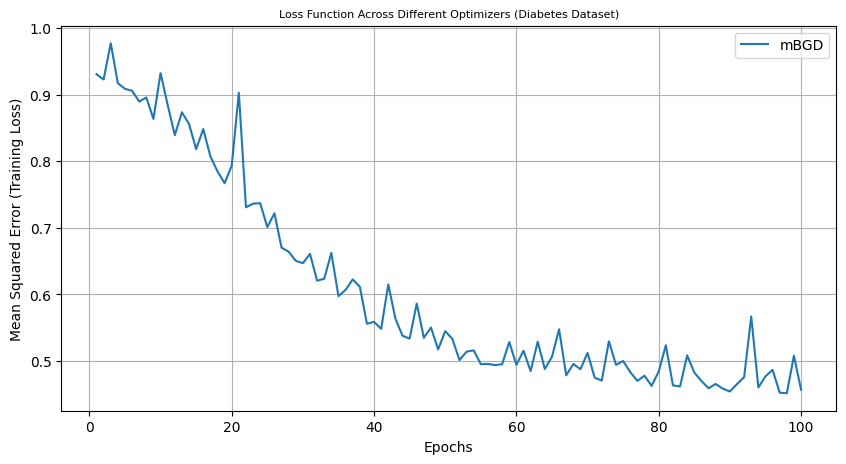

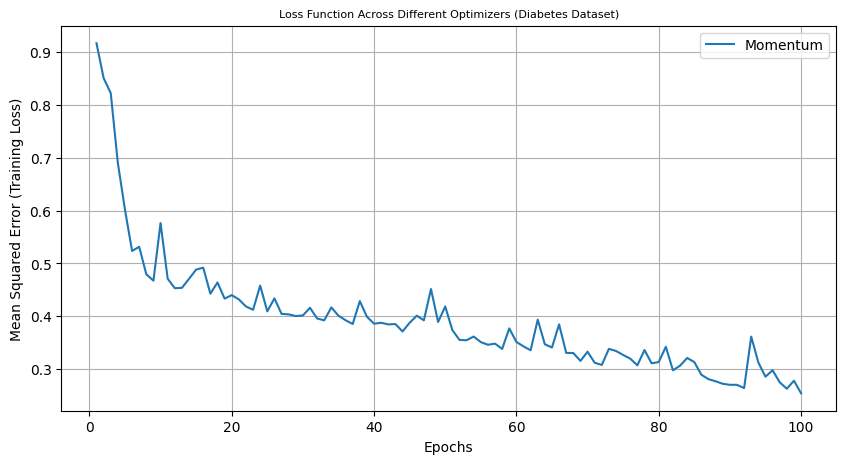

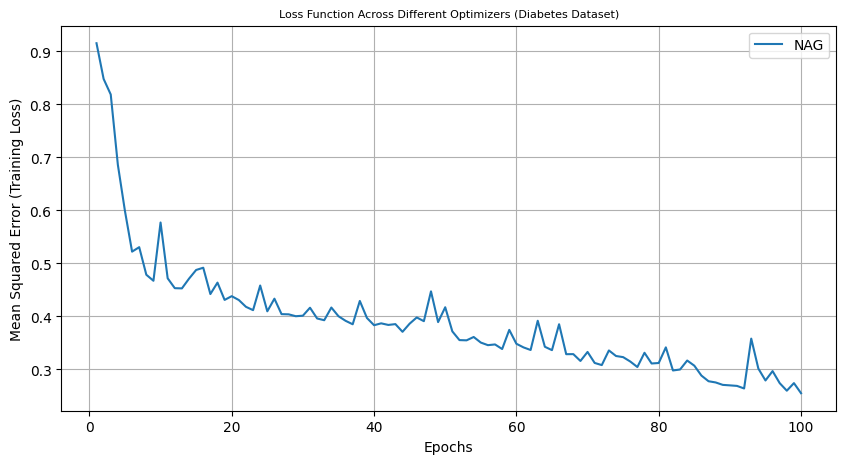

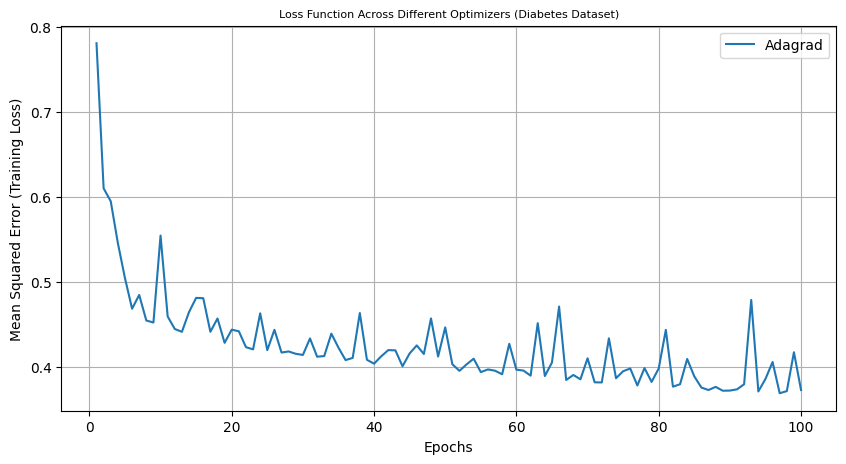

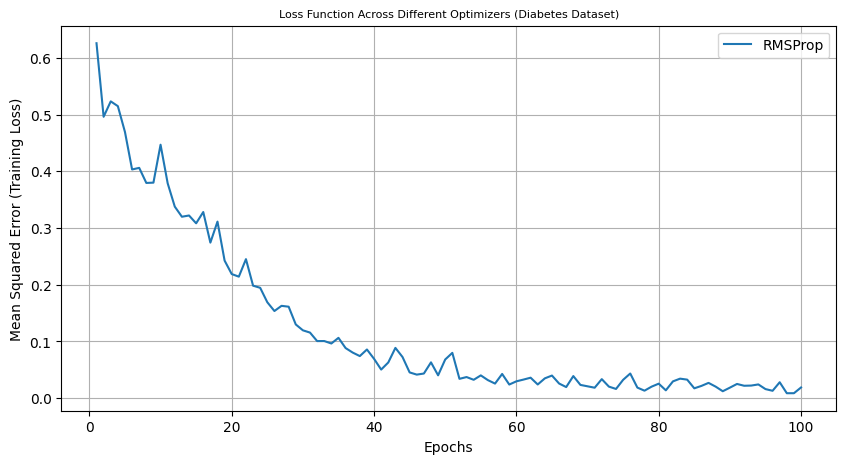

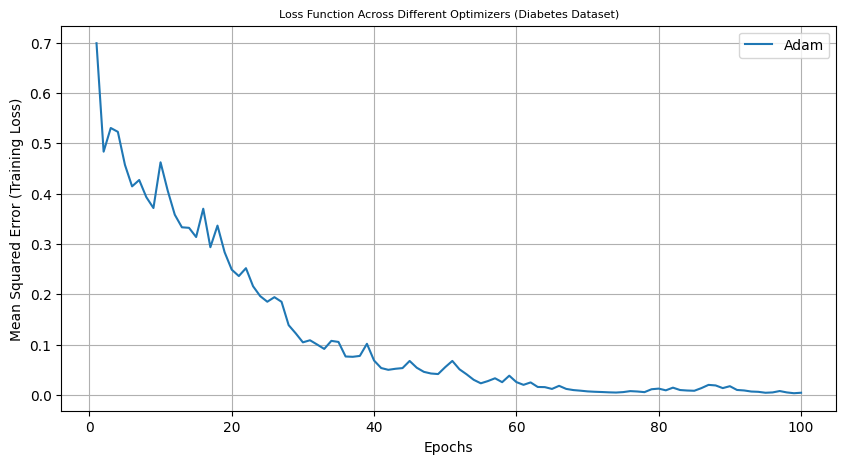

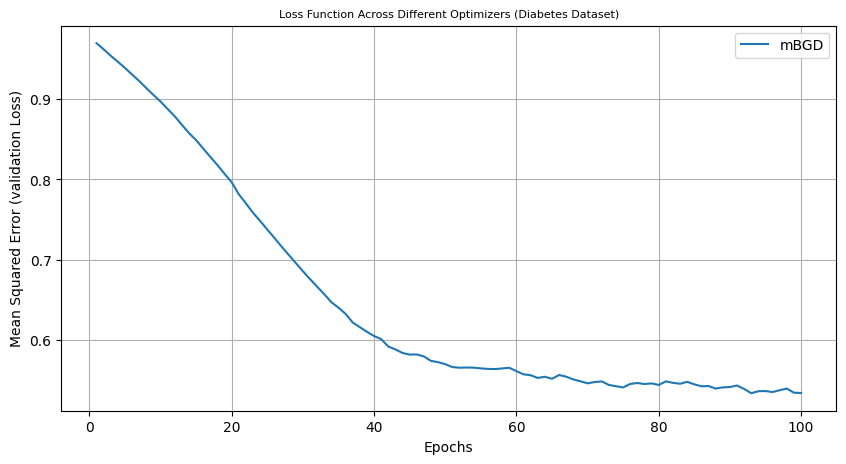

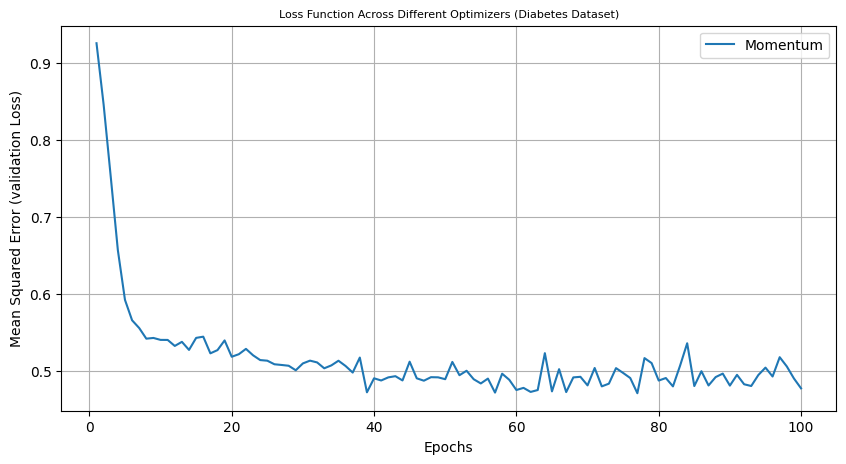

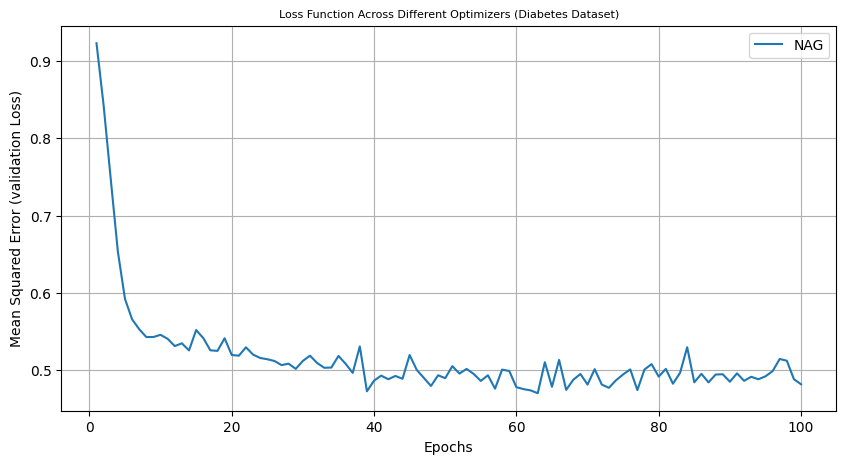

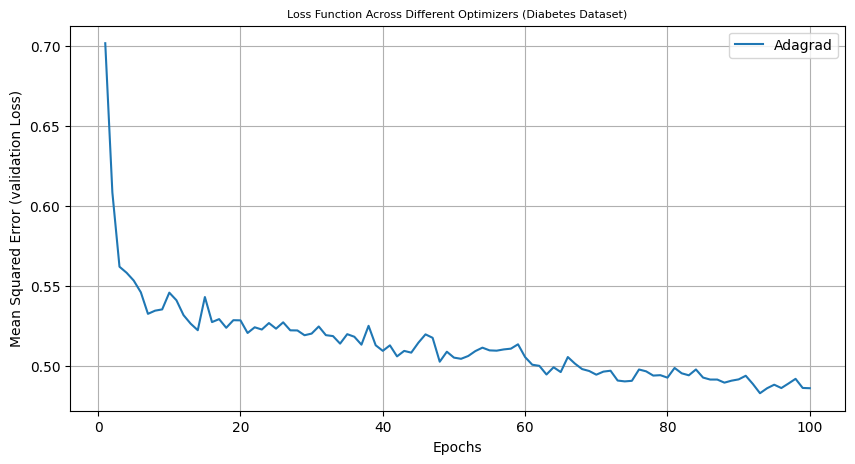

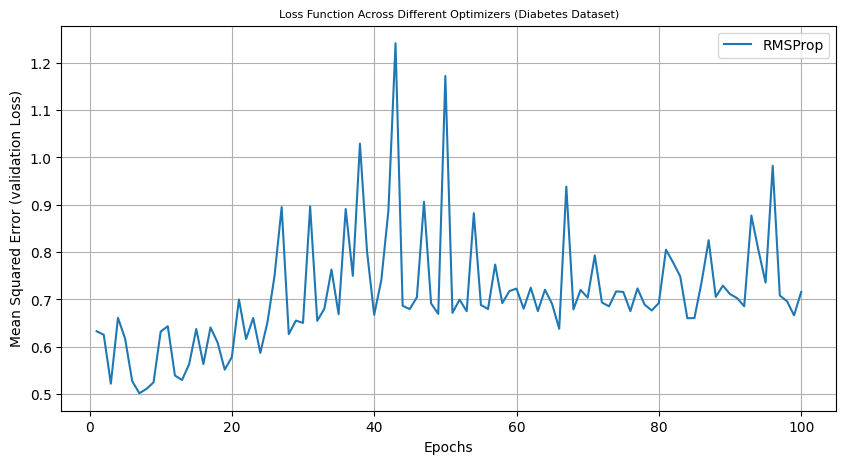

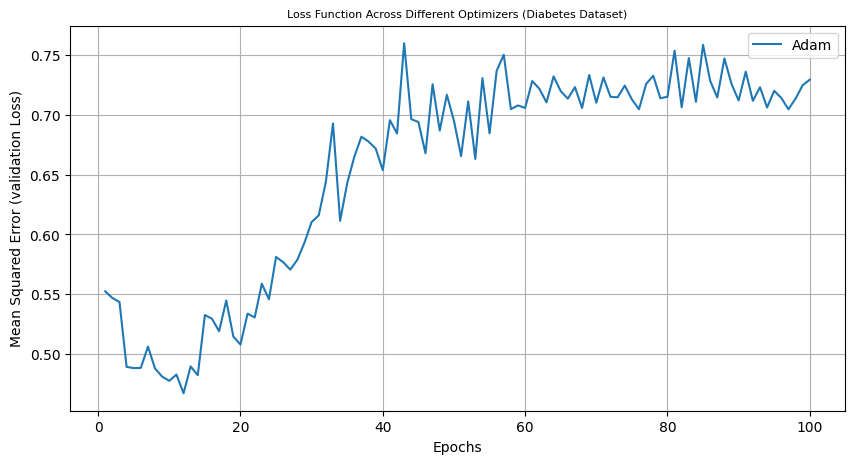

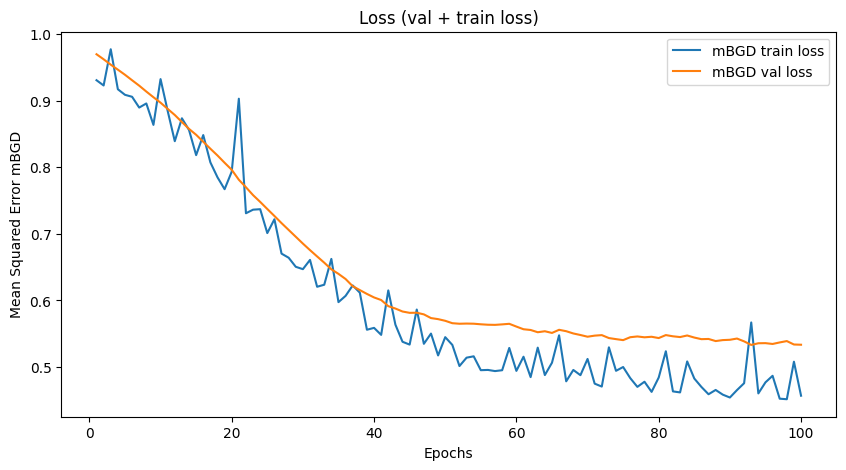

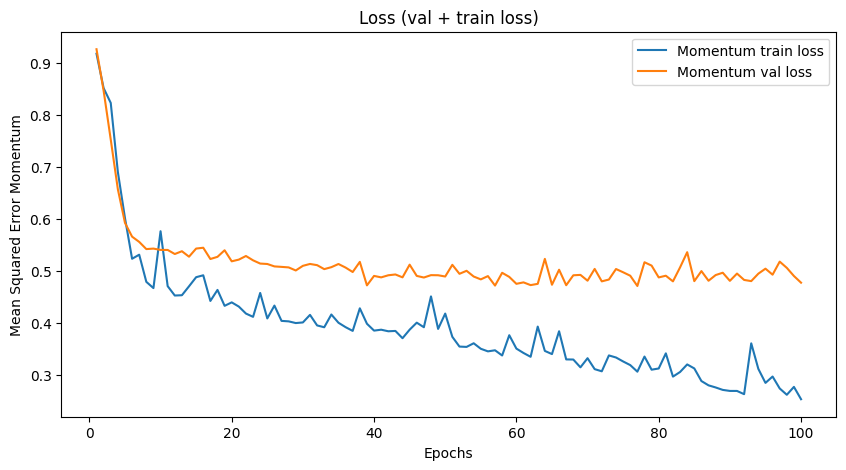

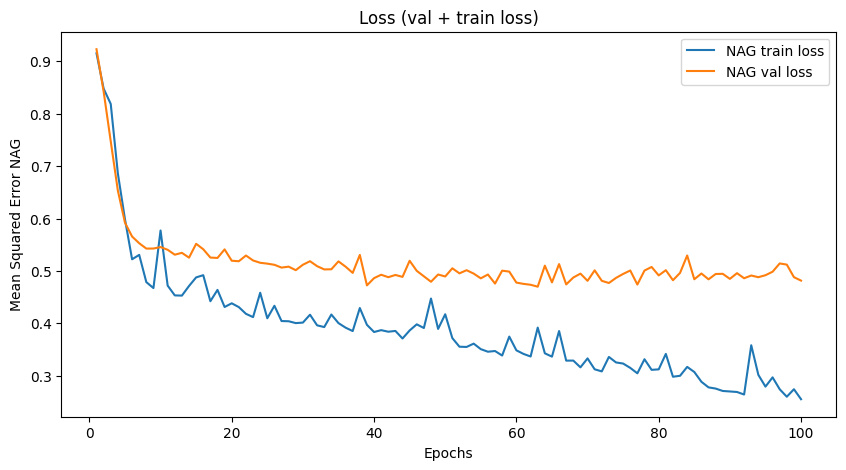

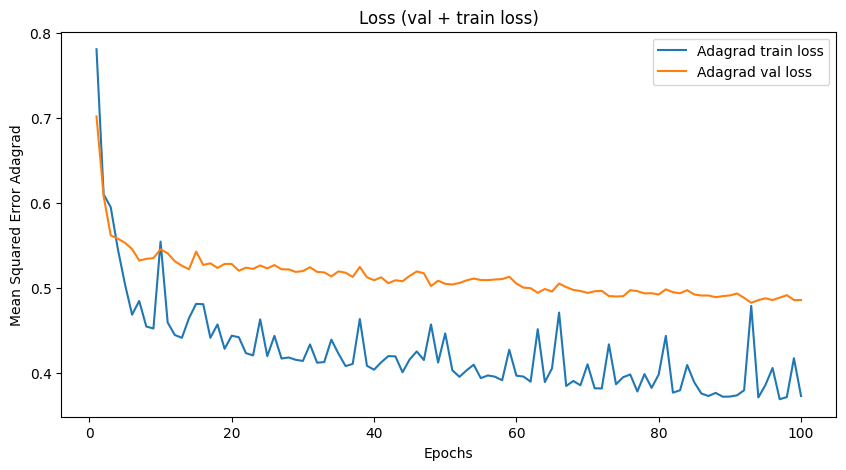

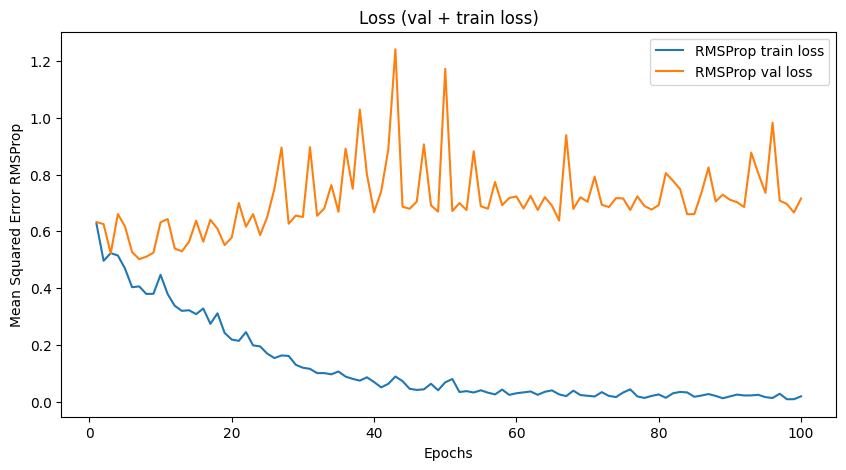

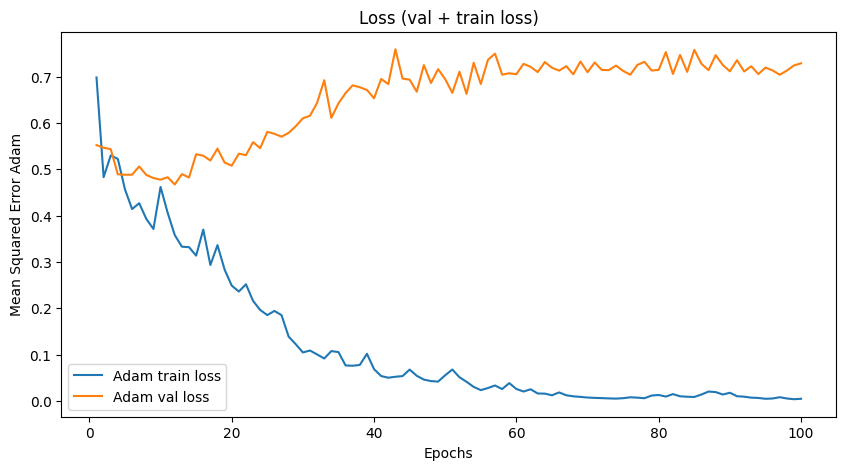

In [15]:
for name, loss in dict_Tloss.items():
    plt.figure(figsize=(10, 5))
    plt.title('Loss Function Across Different Optimizers (Diabetes Dataset)',fontsize=8)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (Training Loss)')
    plt.plot(a,loss, label=name)
    plt.grid(True)
    plt.legend()
    #for c, d in zip(a, loss):
        #plt.annotate(text=f"{d:.3f}",xy=(c, d),fontsize=5)
    plt.savefig(f'Training loss {name}.png',dpi=500)
    plt.show()


for name, loss in dict_Vloss.items():
    plt.figure(figsize=(10, 5))
    plt.title('Loss Function Across Different Optimizers (Diabetes Dataset)',fontsize=8)
    plt.xlabel('Epochs')
    plt.ylabel(f'Mean Squared Error (validation Loss)')
    plt.plot(a,loss, label=name)
    plt.grid(True)
    plt.legend()
#    for c, d in zip(a, loss):
#        plt.annotate(text=f"({d:.3f})",xy=(c, d),fontsize=6)
    plt.savefig(f'validation loss {name}.png',dpi=500)
    plt.show()


for name, loss in dict_Vloss.items():
    plt.figure(figsize=(10, 5))
    plt.title('Loss (val + train loss)')
    plt.xlabel('Epochs')
    plt.ylabel(f'Mean Squared Error {name}')
    plt.plot(a,dict_Tloss[name],label=name+' train loss')
    plt.plot(a,dict_Vloss[name],label=name+" val loss")
    plt.legend()
    plt.savefig(f'combined train and val {name}.png',dpi=500)
    plt.show()




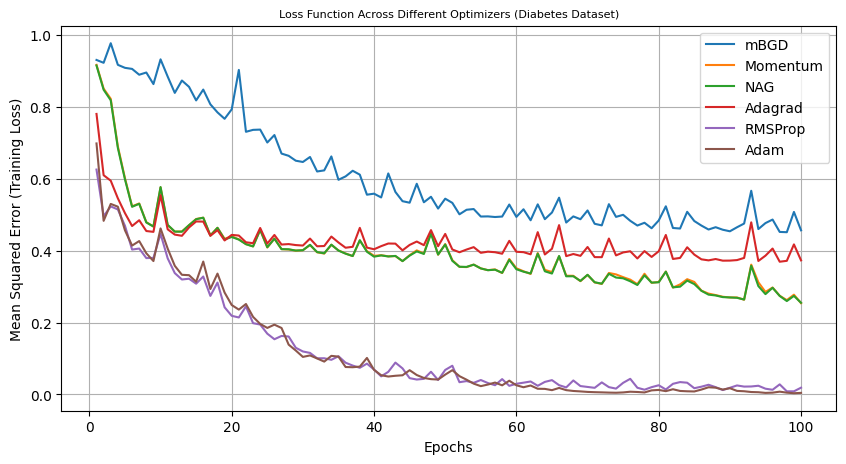

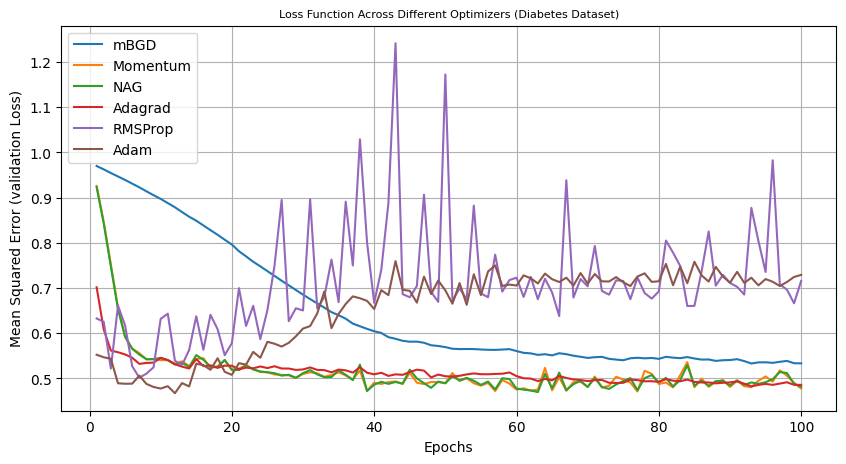

In [16]:
plt.figure(figsize=(10, 5))
for name, loss in dict_Tloss.items():
    plt.title('Loss Function Across Different Optimizers (Diabetes Dataset)',fontsize=8)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (Training Loss)')
    plt.plot(a,loss, label=name)
    plt.grid(True)
    plt.legend()
plt.savefig(f'combined training loss all.png',dpi=500)
plt.show()

plt.figure(figsize=(10, 5))
for name, loss in dict_Vloss.items():
    plt.title('Loss Function Across Different Optimizers (Diabetes Dataset)',fontsize=8)
    plt.xlabel('Epochs')
    plt.ylabel(f'Mean Squared Error (validation Loss)')
    plt.plot(a,loss, label=name)
    plt.grid(True)
    plt.legend()
plt.savefig(f'combined validation loss all.png',dpi=500)
plt.show()

In [17]:

geeky_file = open('TrainingResults.txt', 'wt') 
geeky_file.write("train loss\n "+str(dict_Tloss)+"\nvalidation loss\n "+str(dict_Vloss)+"\n time\n "+str(dict_Tt)) 
geeky_file.close()